### Preliminary Actions: Read the dataset from csv file first. Then create the features DataFrame and the response variable Series. Create dummy variables for geographical regions and rural-urban continuum codes (RUCC).  At the end, create train and test sets.

In [1]:
# There are many warnings regarding the updates in the future releases of the libraries. Ignore them.
import warnings
warnings.filterwarnings("ignore")

# Improt necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
import seaborn as sns

# Load the data set
df = pd.read_csv('wrangled_data.csv')

# define the features DataFrame and the target variable Series
X = df.drop(['state','county','poverty'],axis=1)
y = df['poverty']

# Transform RUCC column from integer to string to be able to create dummy variables
X.RUCC = X.RUCC.astype('str')

# Create dummy variables for region and RUCC
X = pd.get_dummies(X)

# drop one column of the dummy variables for each categorical variable to avoid collinearity. I remove Midwest and RUCC_9.
# Also, the sum of the four education levels is 100 and one of them must be removed to avoid collinearity.
# I pick college/associate_degree and remove it

X.drop(['region_Midwest','RUCC_9','college/associate_degree'],axis=1,inplace=True)

# print the first five rows of X
print('The first five rows of X are\n',X.head())
# X.head()
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=21)

The first five rows of X are
    less_than_high_school  high_school_diploma  bachelors/higher  unemployment  \
0                 12.417               34.331            24.593           5.1   
1                  9.972               28.692            29.547           5.4   
2                 26.236               34.927            12.868           8.4   
3                 19.302               41.816            12.000           6.5   
4                 19.969               32.942            13.050           5.4   

   region_Northeast  region_South  region_West  RUCC_1  RUCC_2  RUCC_3  \
0                 0             1            0       0       1       0   
1                 0             1            0       0       0       1   
2                 0             1            0       0       0       0   
3                 0             1            0       1       0       0   
4                 0             1            0       1       0       0   

   RUCC_4  RUCC_5  RUCC_6  RUCC_7  RUC

### Step 1: Build a linear model

#### 1.1) Run cross-validation and average the scores.

In [3]:
# Build the linear model 
model = LinearRegression()

# Run cross-validation and print the average of scores
scores = cross_val_score(model,X_train,y_train,cv=5)
print('The average of 5-fold cross-validation scores for the linear model is %.3f'%np.mean(scores))

The average of 5-fold cross-validation scores for the linear model is 0.589


#### 1.2) Examine if removing outliers will result in a model with a better performance in prediction. In order to do so, split X_train into 5 folds. Run five tests; in each test, leave one fold out, remove the outliers from the rest and fit a linear model on them. Then, find the score of the model in predicting the left-out fold. At the end, average the five scores and compare it with the average of 5-fold cross-validation scores for the linear model with no removed outliers in step 1.1.

#### P.S.  I consider a data point an outlier if the the absolute value of the external studentized residual corresponding to that point is more than 3. I pick 3 because more than 99% of the observations for a normal distribution fall within 3 standard deviation of the mean.

In [4]:
# Create KFold
kf = KFold(n_splits = 5)
score = np.empty([5])
i = 0
# Loop over the splits of the train set  
for train_index, test_index in kf.split(X_train):
    X_train_kf = X_train.iloc[train_index]
    X_test_kf = X_train.iloc[test_index]
    y_train_kf = y_train.iloc[train_index]
    y_test_kf = y_train.iloc[test_index]
    # fit the model on the X_train_kf and y_train_kf
    model = sm.OLS(y_train_kf,X_train_kf).fit()
    # Define the influence array and create a panda Series with the external studentized residuals
    infl = model.get_influence()
    p = pd.Series(infl.resid_studentized_external,index=X_train_kf.index)
    # Remove the outliers from X_train_kf and y_train_kf
    X_reduced=X_train_kf.loc[p[np.abs(p)<=3].index]
    y_reduced=y_train_kf.loc[p[np.abs(p)<=3].index]
    # Build the classifier on X_reduced and y_reduced, and calculate the score of the model predicting the left-out fold
    clf = LinearRegression()
    clf.fit(X_reduced,y_reduced)
    score[i] = clf.score(X_test_kf,y_test_kf)
    i += 1
# Print the average of five scores
print('The average of five scores is %.3f'%np.mean(score))

The average of five scores is 0.590


#### Observation: The average of five scores is 0.590 which is only 0.001 more than the averaged score of the linear model developed in step 1 for which no outliers were removed. Therefore, removing outliers does not improve the performance of the linear model in prediction.

#### 1.3) Add second-degree interaction and nonlinear terms to the linear model. Then, run 5-fold cross-validation and average the scores. 

In [5]:
# Create linear regression and second-degree polynomial features, and use pipeline
linear = LinearRegression()
poly = PolynomialFeatures(degree = 2, interaction_only = False)
pipeline = make_pipeline(poly, linear)

# Run cross-validation and print the average of scores
scores = cross_val_score(pipeline,X_train,y_train,cv=5)
print('The average of 5-fold cross-validation scores for the linear model which includes second-degree\
 nonlinear and interaction terms is %.3f'%np.mean(scores))

The average of 5-fold cross-validation scores for the linear model which includes second-degree nonlinear and interaction terms is 0.599


#### Observation: The average of 5-fold cross-validation scores after adding second-degree nonlinear and interaction terms to the linear model have increased by 0.010 compared to the linear model without those terms (0.599 compared to 0.589). Since the number of features have increased from 15 to 135, the improvement in the score is artificial and is not reliable. Therefore, adding second-degree nonlinear and interaction terms to the linear model does not improve the performance of the linear model in prediction.

#### 1.4) Fit the linear model (with no nonlinear and interaction terms) on the entire train set (without removing the outliers) and test it on the test set to find the test score. 

In [2]:
# Build the linear model, fit it on the train set
linear = LinearRegression()
linear.fit(X_train,y_train)

# Find the test score and print it
score = linear.score(X_test,y_test)
print('The test score for the linear model is %.3f'%score)

The test score for the linear model is 0.572


In [3]:
linear.coef_

array([ 0.48045518,  0.07418401,  0.0803422 ,  1.14299717, -0.82670217,
        1.27110001,  0.22806483, -3.85180564, -1.82402176, -1.11628727,
       -0.93507498, -0.01574991, -1.12488277, -0.3574059 , -0.57405267])

In [4]:
pd.DataFrame(np.transpose(linear.coef_),columns=['coefficient'],index=X_train.columns)

coefficient
less_than_high_school     0.480455
high_school_diploma       0.074184
bachelors/higher          0.080342
unemployment              1.142997
region_Northeast         -0.826702
region_South              1.271100
region_West               0.228065
RUCC_1                   -3.851806
RUCC_2                   -1.824022
RUCC_3                   -1.116287
RUCC_4                   -0.935075
RUCC_5                   -0.015750
RUCC_6                   -1.124883
RUCC_7                   -0.357406
RUCC_8                   -0.574053

#### 1.5) Build the final linear model by fitting the linear model to the entire data set, and then, simplify the model by removing the features with p-value less than 0.05

In [7]:
# sm.OLS does not have constant by default
X1 = sm.add_constant(X)
model_linear = sm.OLS(y,X1).fit()

# Print the summary of the model
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                poverty   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     308.0
Date:                Tue, 08 Jan 2019   Prob (F-statistic):               0.00
Time:                        21:56:51   Log-Likelihood:                -8804.6
No. Observations:                3141   AIC:                         1.764e+04
Df Residuals:                    3125   BIC:                         1.774e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.3142      1.200      0.262      0.794      -2.039       2.668
less_than_high_school     0.4564      0.019     23.494      0.000       0.418       0.494
high_school_diploma       0.0698      0.020      3.510      0.000       0.031       0.109
bachelors/higher          0.0658      0.019      3.488      0.000       0.029       0.103
unemployment              1.1189      0.045     24.838      0.000       1.031       1.207
region_Northeast         -0.7552      0.326     -2.318      0.021      -1.394      -0.116
region_South              1.4138      0.201      7.029      0.000       1.019       1.808
region_West               0.2012      0.247      0.815      0.415      -0.283       0.685
RUCC_1                   -3.7075      0.298    -12.436      0.000      -4.292      -3.123
RUCC_2                   -1.7199      0.295     -5.833      0.000      -2.298      -1.142
RUCC_3                   -1.0505      0.294     -3.575      0.000      -1.627      -0.474
RUCC_4                   -0.6803      0.340     -2.001      0.045      -1.347      -0.014
RUCC_5                    0.0143      0.464      0.031      0.975      -0.895       0.923
RUCC_6                   -0.8853      0.259     -3.421      0.001      -1.393      -0.378
RUCC_7                   -0.4584      0.275     -1.666      0.096      -0.998       0.081
RUCC_8                   -0.4698      0.335     -1.401      0.161      -1.127       0.187
==============================================================================
Omnibus:                      726.215   Durbin-Watson:                   1.710
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4505.334
Skew:                           0.949   Prob(JB):                         0.00
Kurtosis:                       8.552   Cond. No.                         733.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Constant, region_West, RUCC_5, RUCC_7, and RUCC_8 have p-values higher than 0.05 and can be removed from the model

In [8]:
# drop constant, Region_West, RUCC_5, RUCC_7, and RUCC_8 from X1
X1.drop(['const','region_West','RUCC_5','RUCC_7','RUCC_8'],axis=1,inplace=True)
# Build the linear model with new X1 and print p-values
model_linear = sm.OLS(y,X1).fit()
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                poverty   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     4945.
Date:                Tue, 08 Jan 2019   Prob (F-statistic):               0.00
Time:                        21:57:40   Log-Likelihood:                -8806.9
No. Observations:                3141   AIC:                         1.764e+04
Df Residuals:                    3130   BIC:                         1.770e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
less_than_high_school     0.4584      0.015     30.662      0.000       0.429       0.488
high_school_diploma       0.0698      0.007      9.938      0.000       0.056       0.084
bachelors/higher          0.0693      0.007      9.907      0.000       0.056       0.083
unemployment              1.1255      0.043     26.010      0.000       1.041       1.210
region_Northeast         -0.8608      0.300     -2.869      0.004      -1.449      -0.272
region_South              1.3240      0.180      7.347      0.000       0.971       1.677
RUCC_1                   -3.4688      0.250    -13.866      0.000      -3.959      -2.978
RUCC_2                   -1.4631      0.247     -5.935      0.000      -1.947      -0.980
RUCC_3                   -0.7966      0.247     -3.224      0.001      -1.281      -0.312
RUCC_4                   -0.4238      0.300     -1.413      0.158      -1.012       0.164
RUCC_6                   -0.6279      0.205     -3.068      0.002      -1.029      -0.227
==============================================================================
Omnibus:                      724.816   Durbin-Watson:                   1.707
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4469.600
Skew:                           0.949   Prob(JB):                         0.00
Kurtosis:                       8.527   Cond. No.                         224.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### RUCC_4 has a p-value of higher than 0.05 in the new model and can be removed.

In [9]:
# drop constant, Region_West, RUCC_5, RUCC_8, and RUCC_9 from X1
X1.drop(['RUCC_4'],axis=1,inplace=True)
# Build the linear model with new X1 and print p-values
model_linear = sm.OLS(y,X1).fit()
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                poverty   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     5437.
Date:                Tue, 08 Jan 2019   Prob (F-statistic):               0.00
Time:                        21:57:59   Log-Likelihood:                -8807.9
No. Observations:                3141   AIC:                         1.764e+04
Df Residuals:                    3131   BIC:                         1.770e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
less_than_high_school     0.4586      0.015     30.668      0.000       0.429       0.488
high_school_diploma       0.0693      0.007      9.878      0.000       0.056       0.083
bachelors/higher          0.0680      0.007      9.804      0.000       0.054       0.082
unemployment              1.1221      0.043     25.967      0.000       1.037       1.207
region_Northeast         -0.9000      0.299     -3.012      0.003      -1.486      -0.314
region_South              1.3135      0.180      7.294      0.000       0.960       1.667
RUCC_1                   -3.3891      0.244    -13.903      0.000      -3.867      -2.911
RUCC_2                   -1.3893      0.241     -5.765      0.000      -1.862      -0.917
RUCC_3                   -0.7261      0.242     -3.000      0.003      -1.201      -0.252
RUCC_6                   -0.5635      0.200     -2.824      0.005      -0.955      -0.172
==============================================================================
Omnibus:                      728.522   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4480.276
Skew:                           0.955   Prob(JB):                         0.00
Kurtosis:                       8.530   Cond. No.                         198.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### P.S. sm.OLS is not showing the correct value for R-squared here because  it was 0.596 before removing the features with high p-values but it is 0.946 after removing them. Such a huge jump in R-squared does not make sense. There should be some bug with the command (only regarding R-squared) when there is no constant. R-squared for the data set after removing the features with high p-value is calculated with LinearRegression here.

In [17]:
# Build the linear model and fit it to the dataset with no region_West
model_linear = LinearRegression()
model_linear.fit(X1,y)

# Calculate the r_squared and print it
r_squared = model_linear.score(X1,y)
print('The R-squared of the linear model fitted on the entire dataset after removing the features with high p-values\
 is %.3f'%r_squared)

The R-squared of the linear model fitted on the entire dataset after removing the features with high p-values is 0.596


#### 1.7) Examine if the assumptions associated with linear models, i.e. linearity, independent erros, and normal distribution of errors are valid. To do so, draw residual vs. fitted values plot and quantile-quantile plot.

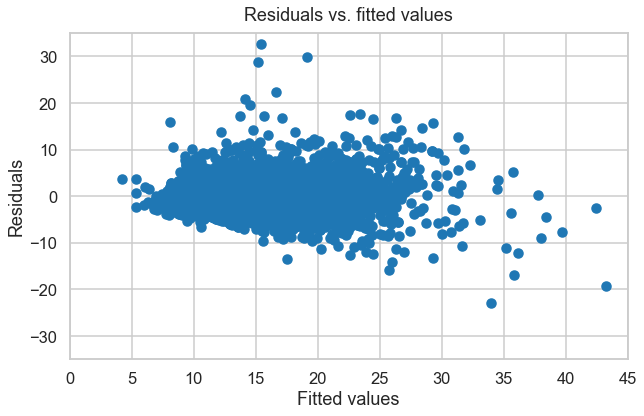

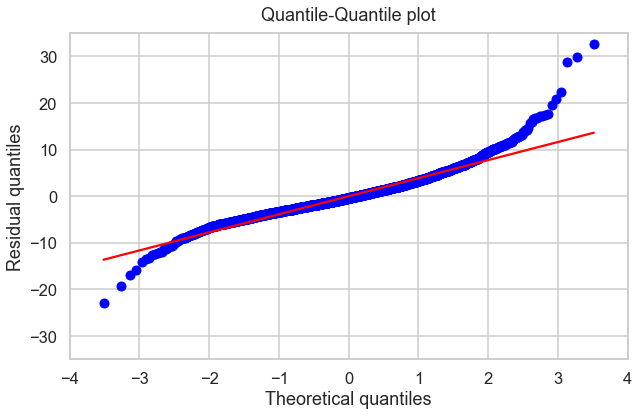

In [19]:
# Set style and context
sns.set_style('whitegrid')
sns.set_context('talk')

#Build the linear model with sm.OLS
model_linear = sm.OLS(y,X1).fit()

# Plot residuals vs. fitted values
figure,ax = plt.subplots(figsize=(10,6))
ax.scatter(model_linear.fittedvalues,model_linear.resid)
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals');
ax.set_title('Residuals vs. fitted values',y=1.02)
ax.axis([0,45,-35,35])

# Plot quantile-quantile plot
figure,ax = plt.subplots(figsize=(10,6))
stats.probplot(model_linear.resid,plot=ax)
ax.set_ylabel('Residual quantiles')
ax.set_title('Quantile-Quantile plot',y=1.02)
ax.axis([-4,4,-35,35])

# Show plots
plt.show()

#### Observation

#### 1) residual vs. fitted values plot
#### 1.a) Linearity: The residuals bounce randomly around the 0 line. This suggests that the assumption of the linear relationship between features and target variable is reasonable.
#### 1.b) Independent errors: The residuals roughly form a horizontal band around the 0 line. This suggests the variances of the error terms are quite equal and the assumption of independent errors is reasonable.

#### 2) Quantile-Quantile plot
#### Normal distribution of errors: The Quantile-Quantile plot shows the distribution of the residuals is close to the normal distribution except it is heavy tailed

### Conclusion 1:

### 1) The final linear model (which has no nonlinear or interaction terms), fitted on the entire data set (with no removed outliers), has the following features and corresponding coefficients after simplification:  less_than_high_school with coefficient 0.4586, high_school_diploma with coefficient 0.0693, bachelors/higher with coefficient 0.0680, unemployment with coefficient 1.1221, region_Northeast with coefficient -0.9 , region_South with coefficient 1.3135, RUCC_1 with coefficient -3.3891, RUCC_2 with coefficient -1.3893, RUCC_3 with coefficient -0.7261, and RUCC_6 with coefficient -0.5635. This model adheres to linearity, independent errors, and normal distribution of errors assumptions.

### 2) The test score of the linear model is 0.571.

### The test score of the linear model is not high. A Random Forest model is developed in the next step.

### Step 2: Develop a Random Forest model

#### 2-1) Build a Random Forest without parameter tuning, run 5-fold cross-validation and average the scores.

In [10]:
# Build the model without parameter tuning. 
forest = RandomForestRegressor(random_state=21)

# Run cross-validation, and average the scores
scores = cross_val_score(forest,X,y,cv=5)
print('The average of 5-fold cross-validation scores for the Random Forest model with no parameter tuning is %.3f'
      %np.mean(scores))

The average of 5-fold cross-validation scores for the Random Forest model with no parameter tuning is 0.499


#### 2.2) Tune parameters of the Random Forest model. (min_samples_leaf lower than 5 could result in overfitting. Therefore, no value below 5 will be tested.)

In [17]:
# Define a function which receives a random forest, parameters, X_train, and y_train as inputs, tune parameters 
# and prints the best score and best parameters

def tuning(forest,parameters,X_train,y_train):
    model = GridSearchCV(forest,param_grid=parameters,cv=5)    
    model.fit(X_train,y_train)
    print('The best score in parameter tuning is: %.3f'%model.best_score_)
    print('The best parameters are: ',model.best_params_)    
    return model

In [22]:
# Build the random forest
forest = RandomForestRegressor(random_state=21)

# Tune parameters
parameters = {'n_estimators':[50,80,100],
              'criterion': ['mse','mae'],
             'min_samples_leaf':[5,7,10],
             'max_features':['auto','sqrt','log2']}
model = tuning(forest,parameters,X_train,y_train)

The best score in parameter tuning is: 0.616
The best parameters are:  {'criterion': 'mse', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100}


#### Best 'n_estimators' is 100 which is the largest tested value. A couple of more values will be tested.

In [18]:
# Build the random forest with tuned parameters
forest = RandomForestRegressor(criterion='mse', max_features='sqrt', min_samples_leaf=5,random_state=21)
# Tune parameter
parameter2 = {'n_estimators':[100,300,500,1000]}
model = tuning(forest,parameter2,X_train,y_train)

The best score in parameter tuning is: 0.618
The best parameters are:  {'n_estimators': 1000}


#### The best score only improved by 0.002 when 'n_estimators' changed from 100 to 1000. Therefore, it is not necessary to test values beyond 1000. I will pick 'n_estimators' equal to 100 to keep the model simpler because the higher values of the parameter will not significantly improve the model.

#### 2.3) Add one more feature to the features DataFrame and find out if it improves the model. In order to create this feature, the dataset is clustered; the cluster is the new feature. The number of clusters is a parameter which will be tuned along with the random forest parameters by grid search.

####   2.3.a) First, I define a function which generates clusters for a train set and predcits clusters for a test set.

In [29]:
#Define clustering function
def clustering(X_train,X_test,n_cluster):
    
    # Build the KMeans cluster, fit it to the train set, create the new feature for the train set, 
    # cocatenate it to the features DataFrame, transform it to dummy variables, and remove the last dummy variable 
    kmeans = KMeans(n_clusters=n_cluster,random_state=21)
    kmeans.fit(X_train)
    new_column_train = kmeans.predict(X_train) 
    new_df_train = pd.DataFrame(new_column_train,columns = ['cluster'], index = X_train.index)
    X_train_extended = pd.concat([X_train,new_df_train],axis=1)
    X_train_extended.cluster = X_train_extended.cluster.astype('str')
    X_train_extended = pd.get_dummies(X_train_extended)
    X_train_extended.drop(['cluster_{}'.format(n_cluster-1)],axis=1,inplace=True)
    
    # Build the new feature for the test set, concatenate it to the features DataFrame of the test set
    # transform it to dummy variables, and remove the last dummy variable 
    new_column_test = kmeans.predict(X_test) 
    new_df_test = pd.DataFrame(new_column_test,columns = ['cluster'], index = X_test.index)
    X_test_extended = pd.concat([X_test,new_df_test],axis=1)
    X_test_extended.cluster = X_test_extended.cluster.astype('str')
    X_test_extended = pd.get_dummies(X_test_extended)
    X_test_extended.drop(['cluster_{}'.format(n_cluster-1)],axis=1,inplace=True)
    
    # Return the new features DataFrame for both train and test sets
    return X_train_extended,X_test_extended

#### 2.3.b) Then I define a function which runs the grid search and finds the best values for number of clusters, n_estimators, min_samples_leaf, criterion, and max_features. Then, it will print the best score of parameter tuning and the best parameters. 

In [30]:
def cluster_forest_SearchCV(cluster_numbers,n_estimators,min_samples_leaf,criterion,max_features,X_train,y_train):
    
    # Create KFold with 5 as the number of splits.
    kf = KFold(n_splits = 5)
    # Create a zero array which will hold the score of each split run. Since the number of splits is 5, the first dimention is 5
    a = np.zeros(shape = (5,len(cluster_numbers),len(n_estimators),len(min_samples_leaf),len(criterion),len(max_features)))
    
    t = 0
    # Loop over the splits of the train set  
    for train_index, test_index in kf.split(X_train):
        X_train_kf = X_train.iloc[train_index]
        X_test_kf = X_train.iloc[test_index]
        y_train_kf = y_train.iloc[train_index]
        y_test_kf = y_train.iloc[test_index]
        
        # Loop over number of clusters
        for i,n_cluster in enumerate(cluster_numbers):
            # Cluster each dataset in train set 
            X_train_kf_extended,X_test_kf_extended = clustering(X_train_kf,X_test_kf,n_cluster)
            # Loop over n_estimators
            for j,n_estimator in enumerate(n_estimators):
                # Loop over min_samples_leaf
                for k,min_sample_leaf in enumerate(min_samples_leaf):
                    # Loop over criterion
                    for l,criteria in enumerate(criterion):
                        # Loop over max features
                        for m,max_feature in enumerate (max_features):
                            # Create the random forest and find the score
                            model = RandomForestRegressor(n_estimators = n_estimator, min_samples_leaf = min_sample_leaf,
                                                   criterion = criteria, max_features = max_feature, random_state=21)
                            model.fit(X_train_kf_extended,y_train_kf)
                            score = model.score(X_test_kf_extended,y_test_kf)
                            # Save the score in the array
                            a[t,i,j,k,l,m] = score
        t += 1
     
    # Average the scores 
    average_score = np.mean(a,axis = 0)
    
    
    #Find the highest average score
    max_score = np.amax(average_score)
    
    # Find the cluster_number, n_estimator, and min_sample_leaf corresponding to the best score
    max_score_index = np.unravel_index(average_score.argmax(), average_score.shape)
    cluster_number = cluster_numbers[max_score_index[0]]
    n_estimator = n_estimators[max_score_index[1]]
    min_sample_leaf = min_samples_leaf[max_score_index[2]]
    criteria = criterion[max_score_index[3]]
    max_feature = max_features[max_score_index[4]]
    
    # Print the best score of parameter tuning and best parameters
    print('The best score is %.3f'%max_score)
    print('\nThe best parameters are:')
    print('Number of clusters: ',cluster_number)
    print('n_estimators: ',n_estimator)
    print('min_samples_leaf: ',min_sample_leaf)
    print('criterion: ',criteria)
    print('max_features: ',max_feature)

#### Tune the parameters and find the test-set score

In [31]:
# Tune the parameters of the random forest fitted on the train set with cluster as the new feature
cluster_numbers = [1,2,5,10]
n_estimators = [50,80,100]
min_samples_leaf = [5,7,10]
criterion = ['mse','mae']
max_features = ['auto','sqrt','log2']
cluster_forest_SearchCV(cluster_numbers,n_estimators,min_samples_leaf,criterion,max_features,X_train,y_train)

The best score is 0.620

The best parameters are:
Number of clusters:  2
n_estimators:  100
min_samples_leaf:  5
criterion:  mse
max_features:  sqrt


#### Observation: The best score is 0.620 which is only 0.004 more than the best score of the random forest model with no cluster feature obtained in step 2.2. This improvement in the best score is not quite reliable since the model developed in this step has one more feature than the one developed in step 2. Therefore, adding the cluster feature to the features DataFrame does not improve the performance of the Random Forest model in prediction.

#### 2.3) Fit the random forest model with tuned parameters in step 2.2 to the entire train set. Then calculate the test score.

In [19]:
# Build the random forest with tuned parameters
forest = RandomForestRegressor(criterion='mse', max_features='sqrt', min_samples_leaf=5, n_estimators=100, random_state=21)
# Fit the random forest to the train set
forest.fit(X_train,y_train)

# Find the test score and print it
score = forest.score(X_test,y_test)
print('The test score for the random forest model is %.3f'%score)

The test score for the random forest model is 0.638


#### 2.4) Build the final random forest by fitting the random forest to the entire data set and sort the features based on theit importance.

In [26]:
# Build the random forest with tuned parameters
model_forest = RandomForestRegressor(criterion='mse', max_features='sqrt', min_samples_leaf=5, n_estimators=100, random_state=21)
# Fit the random forest to the entire set
model_forest.fit(X,y)

# Sort the features based on their importance
features = pd.DataFrame(model_forest.feature_importances_, index = X.columns,
                        columns=['importance']).sort_values('importance',ascending=False)
features

importance
less_than_high_school    0.344908
unemployment             0.234495
bachelors/higher         0.210041
region_South             0.077719
high_school_diploma      0.055807
RUCC_1                   0.039337
region_West              0.006506
RUCC_7                   0.005771
RUCC_3                   0.005403
RUCC_6                   0.005209
region_Northeast         0.004265
RUCC_2                   0.003938
RUCC_4                   0.002886
RUCC_8                   0.002524
RUCC_5                   0.001191

#### The most important features in the Random Forest model are less_than_high_school, unemployment, and bachelors/higher.

### Conclusion 2:
### 1) The final random forest model, which is fitted on the entire data set (with no extra feature and RUCC as a quantitative variable), has the following parameters: criterion = mse, max_features = sqrt, min_samples_leaf = 5, and n_estimators = 100.
### 2) The test score of the random forest model is 0.638.
### 3) The most important features in forming the Random Forest model are less_than_high_school, unemployment, and bachelors/higher.

### Final Conclusion:
### The random forest model with tuned parameters is selected over the linear model because its test score is around 12 percent better (0.638 compared to 0.571). The most important features in forming the Random Forest model are less_than_high_school, unemployment, and bachelors/higher.